#BERT 기반 단일 문장 분류 모델 학습

https://raki-1203.github.io/boostcamp_ai_tech/week_9/03.-single-sentence-classification-based-BERT-train/

In [1]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
os.chdir("/gdrive/MyDrive/AIFFEL/230710")
os.getcwd()

Mounted at /gdrive


'/gdrive/MyDrive/AIFFEL/230710'

라이브러리

In [ ]:
!pip install transformers datasets wandb accelerate

In [4]:
import os
import pandas as pd
import re
import numpy as np
import os
import keras
import urllib.request
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import sys
from accelerate import Accelerator


import random
import logging
from IPython.display import display, HTML
import datasets
from datasets import load_dataset, load_metric, ClassLabel, Sequence
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoModel, AutoTokenizer, BertTokenizer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

Data

In [5]:
data_dir = 'train.csv'
df = pd.read_csv(data_dir)

#data shuffle
df = df.sample(frac=1)

def preprocess_sentence(sentence):

    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

def check_class(it):
    if '협박' in it:
        return 0
    elif '갈취' in it:
        return 1
    elif '직장 내 괴롭힘' in it:
        return 2
    elif '기타 괴롭힘' in it:
        return 3
    else:
        return 4

df['data'] = df['conversation'].apply(lambda it : preprocess_sentence(it))
df['label'] = df['class'].apply(lambda it: check_class(it))

df = df[['data', 'label']]

df.head(3)

,data,label
873,와 철수 신발 샀어 ? 어어 . 하나 샀어 나도 하나 갖고 싶다 응 ? ? 철수야 ...,1
801,선배님 안녕하세요 . 오랜만이에요 . 방학 잘 보내셨어요 ? 야 말도마 . 쌍수하느...,1
2443,니가 나 따라한다는 애구나 ? 내가 ? 나 너 안따라해 . 머라는거야 . 여기 사진...,3


학습 문장 최대 길이 : 909
학습 문장의 평균 길이 : 235.78683544303797


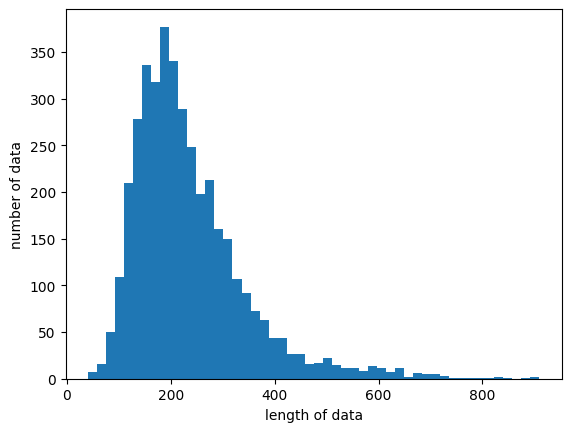

In [6]:
#학습 리뷰 길이조사
print('학습 문장 최대 길이 :',max(len(l) for l in df['data']))
print('학습 문장의 평균 길이 :',sum(map(len, df['data']))/len(df['data']))

plt.hist([len(s) for s in df['data']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

학습 문장 최대 길이 : 400
학습 문장의 평균 길이 : 227.2318987341772


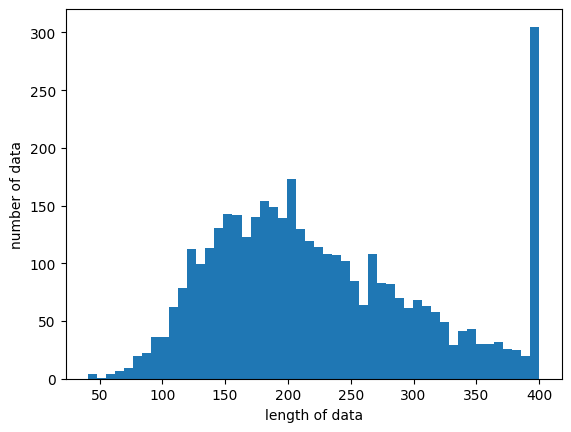

In [ ]:
# 문장 자르기 함수
max_length = 400

def truncate_sentence(sentence, max_length):
    if len(sentence) > max_length:
        return sentence[:max_length]
    else:
        return sentence

# 'data' 열의 문장 자르기
df['data'] = df['data'].apply(lambda x: truncate_sentence(x, max_length))


#학습 리뷰 길이조사
print('학습 문장 최대 길이 :',max(len(l) for l in df['data']))
print('학습 문장의 평균 길이 :',sum(map(len, df['data']))/len(df['data']))

plt.hist([len(s) for s in df['data']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

In [7]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=42)

print(len(train_data))
print(len(test_data))
print(len(valid_data))

3199
395
356


Fine-tuning

In [8]:
MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [9]:
tokenized_train_sentences = tokenizer(
    list(train_data['data']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

tokenized_test_sentences = tokenizer(
    list(test_data['data']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

print(tokenized_train_sentences[0])
print(tokenized_train_sentences[0].tokens)
print(tokenized_train_sentences[0].ids)
print(tokenized_train_sentences[0].attention_mask)

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '야', '[UNK]', '응', '상', '##철', '##아', '왜', '.', '매', '##점', '가', '##서', '빵', '좀', '사', '##와', '돈', '##은', '.', '?', '아', '##나', '지', '##난', '##번', '##에', '덜', '##맞', '##았', '##나', '니', '##가', '사', '##야', '##지', '?', '상', '##철', '##아', '나', '이', '##건', '책', '살', '돈', '##이', '##라', '##서', '안', '##돼', '진', '##짜', '짜', '##증', '##나', '##게', '하', '##네', '.', '빨', '##리가', '##서', '빵', '사', '##오', '##라고', '그', '##럼', '조', '##금', '##만', '보', '##태', '##주', '##면', '안', '##될', '##까', '?', '이', '##게', '돌', '##았', '##나', '빨', '##리', '안', '##사와', '?', '응', '.', '알', '##았', '##어', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

In [10]:
train_label = train_data['label'].values
test_label = test_data['label'].values

print(train_label[0])
print(test_label[0])

1
0


In [11]:
class SingleSentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = SingleSentDataset(tokenized_train_sentences, train_label)
test_dataset = SingleSentDataset(tokenized_test_sentences, test_label)

In [52]:
type(train_dataset)

__main__.SingleSentDataset

In [53]:
train_dataset[0]

<ipython-input-32-d0b76757ee46>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'input_ids': tensor([   101,   8982,   9004,   9638,  49543,   8843,  52560,   9689,  22333,
           9056,   9524,  16985,    119,   9056,   9737,  16985,  11287,  12424,
           9690,  18392,  41521,  21711,   9521, 118798,  48549,    119,   9687,
         119057,  33188,  48345,   9303,    136,   9638,  14153,   9519,  33077,
          12092,   8996,  11287,   9551,  23811,  16439,   9294,  12424,  21614,
          12508,   9283,  47908,  17196,  16439,    119,   9670,  89523,   9356,
          29935, 119221,  21711, 118632,  12965,    136,   9519,  25503,  96279,
          48549,   8996,  18392,  18382,   8996,  11287,   8843,  41584,  28188,
          60362,  41521,   9497,   9056,   8843,  41584,  12638,    119,   9011,
            119,   9952,  82490,  12092,   9388,  12508,  14867,   9004,   9657,
          27792,  38401,   9388,  32815,  41521,  21711,   9069, 118775,   9672,
          37601,   9521,  14523,    136,   8932,  88168,   9689,  11018,  71439,
          28911

In [ ]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,             # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_steps=500,
    save_total_limit=2
)

num_labels = 4

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = num_labels)
model.to("cuda")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

trainer.train() # 1 epoch에 대략 30분 정도 소요됩니다 :-)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

Step,Training Loss


성능평가

In [17]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

In [18]:
trainer.evaluate(eval_dataset=test_dataset)

<ipython-input-11-d0b76757ee46>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Trainer is attempting to log a value of "[0.75647668 0.69662921 0.88082902 0.69911504]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.76842105 0.72093023 0.85       0.69298246]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.74489796 0.67391304 0.91397849 0.70535714]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.7038449048995972,
 'eval_accuracy': 0.7569620253164557,
 'eval_f1': array([0.75647668, 0.69662921, 0.88082902, 0.69911504]),
 'eval_precision': array([0.76842105, 0.72093023, 0.85      , 0.69298246]),
 'eval_recall': array([0.74489796, 0.67391304, 0.91397849, 0.70535714]),
 'eval_runtime': 13.8598,
 'eval_samples_per_second': 28.5,
 'eval_steps_per_second': 0.505}

Prediction

In [ ]:
from transformers import pipeline

nlp_sentence_classif = pipeline('sentiment-analysis',model=model, tokenizer=tokenizer, device=0)

print(nlp_sentence_classif('너는 그일을 왜 그렇게 하니',model= model))
print(nlp_sentence_classif('너 때문에 진짜 짜증나',model= model))
print(nlp_sentence_classif('정말 재밌고 좋았어요.',model= model))